In [1]:
import pandas as pd
import glob
from tqdm.notebook import tqdm

OPENALEX = '/scratch/fl1092/OpenAlex/openalex'
# Directory that contains openalex dataset
# replace this with the directory where you store your local copy of OpenAlex data
# This directory contains:
# PaperYear.csv

DIR = '../data/study_4_data' # data pertaining to this specific research project

LARGEFILE = '../data/large' # data files larger than 100MB, download from FigShare

def printShape(df, cols=[], msg=''):
    
    print(df.shape, end='  ')
    for col in cols:
        print(col, df[col].nunique(), end='  ')
    print(msg)
    
    return df

In [2]:
import matplotlib
from matplotlib import pyplot as plt 

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

# Load data

## Data availability status

In [3]:
import re

def paperIdtoInt(x):

    return int(x.replace('https://openalex.org/W', ''))

def isUponRequest(text):

    # Use regex to check whether the data availability statement indicates that the data is available upon request
    
    text = str(text)

    p1 = r"data.*?available.*?(?:upon|on).*?request"
    p2 = r"contact .*? for data"
    p3 = r"requests for.*?data.*?addressed to"
    
    if re.search(p1, text, re.IGNORECASE) is not None or re.search(p2, text, re.IGNORECASE) or re.search(p3, text, re.IGNORECASE):
        return True
    else:
        return False


def checkNewData(text):

    # Use regex to check whether the data availability statement indicates that the study curates new datasets

    pattern = r"""
        data\s+
        [\w\s,\-\.]+?
        (?:
            are\s+provided\s+with|
            are\s+available\s+within|
            are\s+available\s+without\s+restriction|
            are\s+included\s+in|
            are\s+present\s+in|
            deposited\s+in|
            deposited\s+at|
            source\s+data\s+file
        )
    """

    if "data generated" in str(text).lower():
    
        regex = re.compile(pattern, re.IGNORECASE | re.VERBOSE)
        matches = regex.findall(str(text))
    
        if len(matches) > 0: return True
            
    return False

In [4]:
%%time
dfs = [
    pd.read_csv(file, usecols=[
        'paper_ids','journal','publication_year','is_open_access',
        'data_availability','content_type','titles'
    ]) for file in glob.glob(f'{DIR}/data_availability_statement/*.csv')
]
    
df = (
    pd.concat(dfs, ignore_index=True, sort=False)
    .assign(PaperID=lambda df: df.paper_ids.apply(paperIdtoInt))
    .rename(columns={'publication_year':'Year', 'journal':'Journal'})
    
    .drop(['paper_ids'], axis=1)
    .drop_duplicates()
    .pipe(printShape, cols=['PaperID']) # 91386
    
    .assign(UponRequest=lambda df: df.data_availability.apply(isUponRequest))
    .assign(NewData=lambda df: df.data_availability.apply(checkNewData) | df.UponRequest )
)

(91386, 7)  PaperID 91386  
CPU times: user 2.19 s, sys: 44.9 ms, total: 2.23 s
Wall time: 4.64 s


## Citations and paper characteristics

In [5]:
%%time
paperYear = pd.read_csv(f'{LARGEFILE}/PaperYear.csv').pipe(printShape) # 257748845

(257748845, 2)  
CPU times: user 37.4 s, sys: 3.2 s, total: 40.6 s
Wall time: 1min 22s


In [15]:
%%time
selfCite = ( # self citations (scientists citing themselves)
    pd.read_csv(f'{DIR}/SelfCitations.csv', usecols=['CitedPaperID','CitingPaperID'])
    .drop_duplicates().rename(columns={'CitedPaperID': 'PaperID'})
)

selfCiteCount = (
    selfCite
    .groupby('PaperID').CitingPaperID.nunique().reset_index()
    .rename(columns={'CitingPaperID': 'SelfCitations'})
)


sameCountry = ( # country self-citations (authors of citing papers and cited papers are from the same country)
    pd.read_csv(f'{DIR}/SameCountryCitations.csv', usecols=['CitedPaperID','CitingPaperID'])
    .drop_duplicates().rename(columns={'CitedPaperID': 'PaperID'})
)

CPU times: user 960 ms, sys: 66.6 ms, total: 1.03 s
Wall time: 2.15 s


In [6]:
%%time
citations = (
    pd.concat(
        [pd.read_csv(file) for file in tqdm(glob.glob(f'{DIR}/citations/*'))],
        ignore_index=True, sort=False
    )

    .merge(paperYear.rename(columns={'PaperID':'CitingPaperID','Year':'CitingYear'}), on='CitingPaperID')
    .merge(paperYear.rename(columns={'Year':'CitedYear'}), on='PaperID')
    
    .query('CitingYear <= 2023')
    .query('CitedYear <= 2020')
    .pipe(printShape, cols=['PaperID'])
)

citationCount = (
    citations.groupby('PaperID').CitingPaperID.nunique().reset_index()
    .pipe(printShape, cols=['PaperID'])
    .rename(columns={'CitingPaperID':'TotalCitations'})
)
# (5040838, 4)  PaperID 78008  
# (78008, 2)  PaperID 78008 

  0%|          | 0/7 [00:00<?, ?it/s]

(5040838, 4)  PaperID 78008  
(78008, 2)  PaperID 78008  
CPU times: user 3min 18s, sys: 13 s, total: 3min 31s
Wall time: 7min 6s


In [7]:
fieldDomain = pd.read_csv(f'{DIR}/FieldDomain.csv')

paperField = (
    pd.read_csv(f'{DIR}/PaperMaxTopic.csv')
    .merge(fieldDomain, on='FieldID')
    .drop('FieldID', axis=1)
)

In [8]:
paperField.domain_display_name.value_counts()

domain_display_name
Physical Sciences    1568260
Life Sciences        1083834
Health Sciences       792368
Social Sciences       213583
Name: count, dtype: int64

In [33]:
%%time
paperCountry = (
    pd.read_csv(f'{OPENALEX}/cleaned_data/PaperCountry.csv')
    .pipe(printShape, cols=['PaperID', 'country_code'])
)

(123301358, 3)  PaperID 102371394  country_code 226  
CPU times: user 51.4 s, sys: 3.96 s, total: 55.4 s
Wall time: 1min 55s


In [43]:
paperCountry = (
    paperCountry[paperCountry.PaperID.isin(df.PaperID)]
    .pipe(printShape, cols=['PaperID','country_code'])
    .sort_values(by='AuthorCount', ascending=False)
    
    .drop_duplicates(subset=['PaperID'], keep='first')
    .drop('AuthorCount', axis=1)
    .pipe(printShape, cols=['PaperID','country_code'])
    
    .merge(df[['PaperID']], on='PaperID', how='right')
    .fillna({'country_code':'Unknown'})
    .pipe(printShape, cols=['PaperID','country_code'])
)

(127670, 3)  PaperID 74522  country_code 201  
(74522, 2)  PaperID 74522  country_code 138  
(91386, 2)  PaperID 91386  country_code 139  


## Whiteness

In [16]:
def computeCitation(citations, countryWhiteness):

    return (
        citations
        .pipe(printShape, cols=['PaperID'], msg='all citations')

        .merge(selfCite.assign(Self=True), on=['PaperID','CitingPaperID'], how='left')
        .fillna({'Self': False})
        .query('Self==False')
        .pipe(printShape, cols=['PaperID'], msg='remove self-citations')
        
        .merge(countryWhiteness.rename(columns={'PaperID': 'CitingPaperID'}), on='CitingPaperID')
        .pipe(printShape, cols=['PaperID'], msg='country whiteness')
        
        .groupby(['PaperID', 'NonWhite']).CitingPaperID.nunique().reset_index()
        .rename(columns={'CitingPaperID': 'Count'})
        .pipe(printShape, cols=['PaperID'])
    )


with pd.option_context('future.no_silent_downcasting', True):
    
    allNorthSouth = (
        pd.concat([
            pd.read_csv(f'{DIR}/author_whiteness/AllGlobalNorthCountries.csv').assign(NonWhite=False),
            pd.read_csv(f'{DIR}/author_whiteness/AllGlobalSouthCountries.csv').assign(NonWhite=True)
        ], ignore_index=True, sort=False)
        
        .pipe(printShape, cols=['PaperID'], msg='country')
        
        .drop_duplicates(subset=['PaperID'], keep=False)
        .pipe(printShape, cols=['PaperID'], msg='drop-dup')
    )

    hasNorth = (
        citations[['CitingPaperID']].rename(columns={'CitingPaperID':'PaperID'}).drop_duplicates()
        .pipe(printShape)
        .merge(
            pd.read_csv(f'{DIR}/author_whiteness/HasGlobalNorthCountries.csv').assign(NonWhite=False),
            on='PaperID', how='left'
        )
        .fillna({'NonWhite': True})
        .pipe(printShape)
    )

    majorityNorth = (
        citations[['CitingPaperID']].rename(columns={'CitingPaperID':'PaperID'}).drop_duplicates()
        .pipe(printShape)
        .merge(
            (
                pd.read_csv(f'{DIR}/author_whiteness/GlobalNorthCountriesPercentage.csv')
                .query('Percentage > 0.5')
                .assign(NonWhite=False)
            ), on='PaperID', how='left'
        )
        .fillna({'NonWhite': True})
        .pipe(printShape)
    )


    countryAllNSCitation = computeCitation(citations, allNorthSouth)
    countryHasNCitation = computeCitation(citations, hasNorth)
    countryMajorNCitation = computeCitation(citations, majorityNorth)
    
# (2185108, 2)  PaperID 2185108  country
# (2185108, 2)  PaperID 2185108  drop-dup
# (2630587, 1)  
# (2630587, 2)  
# (2630587, 1)  
# (2630587, 3)  
# (5040838, 4)  PaperID 78008  all citations
# (5018605, 5)  PaperID 78002  remove self-citations
# (3629037, 6)  PaperID 76888  country whiteness
# (143551, 3)  PaperID 76888  
# (5040838, 4)  PaperID 78008  all citations
# (5018605, 5)  PaperID 78002  remove self-citations
# (5018605, 6)  PaperID 78002  country whiteness
# (149287, 3)  PaperID 78002  
# (5040838, 4)  PaperID 78008  all citations
# (5018605, 5)  PaperID 78002  remove self-citations
# (5018605, 7)  PaperID 78002  country whiteness
# (150281, 3)  PaperID 78002

(2185108, 2)  PaperID 2185108  country
(2185108, 2)  PaperID 2185108  drop-dup
(2630587, 1)  
(2630587, 2)  
(2630587, 1)  
(2630587, 3)  
(5040838, 4)  PaperID 78008  all citations
(5018605, 5)  PaperID 78002  remove self-citations
(3629037, 6)  PaperID 76888  country whiteness
(143551, 3)  PaperID 76888  
(5040838, 4)  PaperID 78008  all citations
(5018605, 5)  PaperID 78002  remove self-citations
(5018605, 6)  PaperID 78002  country whiteness
(149287, 3)  PaperID 78002  
(5040838, 4)  PaperID 78008  all citations
(5018605, 5)  PaperID 78002  remove self-citations
(5018605, 7)  PaperID 78002  country whiteness
(150281, 3)  PaperID 78002  


# Descriptive figures

In [11]:
def processWhiteRegion(row):

    r = row['region']
    sub = row['sub-region']
    country = row['country']

    if r == 'Asia' or r == 'Africa' or r=='Europe':
        return r
    elif r == 'Americas':
        return sub
    elif r == 'Oceania':
        if sub == 'Australia and New Zealand':
            return sub
        else:
            return r

def processNorthSouth(row):

    # True: global south
    # False: global north

    r = row['region']
    sub = row['sub-region']
    country = row['country']

    if country == 'JP' or country == 'IL' or country == "KR":
        return False

    if r == 'Asia' or r == 'Africa':
        return True
    elif r == 'Americas':
        if sub == 'Latin America and the Caribbean':
            return True
        else: # north america
            return False
    elif r == 'Oceania':
        if sub == 'Australia and New Zealand':
            return False
        else:
            return True
    elif r == "Europe":
        return False
        

nonWhite = pd.DataFrame(
    {
        'ProcessedRegion': ['Asia', 'Africa', 'Oceania', 'Latin America and the Caribbean',
                   'Europe', 'Australia and New Zealand', 'Northern America'],
        'nonWhite': [True, True, True, True, False, False, False]
    }
)

continents = (
    pd.read_csv('../data/continents2.csv', usecols=['alpha-2', 'region', 'sub-region', 'name'])
    .rename(columns={'alpha-2': 'country'})
    .pipe(printShape)
    
    .dropna()
    .pipe(printShape)
    
    .assign(ProcessedRegion=lambda df: df.apply(processWhiteRegion, axis=1))
    .merge(nonWhite, on='ProcessedRegion')
    .pipe(printShape, cols=['country'])

    .assign(GlobalSouth=lambda df: df.apply(processNorthSouth, axis=1))
    .pipe(printShape, cols=['country'])

    [['country','nonWhite','GlobalSouth','sub-region']]
    .rename(columns={'country':'country_code'})
)

(249, 4)  
(247, 4)  
(247, 6)  country 247  
(247, 7)  country 247  


In [12]:
continents.head()

,country_code,nonWhite,GlobalSouth,sub-region
0,AF,True,True,Southern Asia
1,AX,False,False,Northern Europe
2,AL,False,False,Southern Europe
3,DZ,True,True,Northern Africa
4,AS,True,True,Polynesia


In [13]:
authorCount = pd.read_csv(f'{DIR}/author_whiteness/PaperAuthorCount.csv').rename(columns={'Count':'Total'})

papCountry = (
    pd.read_csv(f'{DIR}/author_whiteness/PaperCountry.csv')
    .pipe(printShape, ['PaperID'])

    .merge(authorCount, on='PaperID')
    .assign(Percent=lambda df: df.AuthorCount / df.Total)
    .pipe(printShape, ['PaperID'])

    .query('Percent>=0.5')
    .pipe(printShape, ['PaperID'])
)

(5176574, 3)  PaperID 3429512  
(4364869, 5)  PaperID 2877577  
(3004894, 5)  PaperID 2775483  


In [16]:
def countryCitationsUponRequest(citations, sameCountry=sameCountry, selfCitation=selfCite, byYear=False):
    
    dataAvaCitingCountries = (
        df[['PaperID','UponRequest']]
        
        .merge(citations, on='PaperID')
    )

    if sameCountry is not None:
        dataAvaCitingCountries = (
            dataAvaCitingCountries
            .merge(sameCountry.assign(SameCountry=1), on=['PaperID','CitingPaperID'], how='left')
            .pipe(printShape, ['PaperID','CitingPaperID'])

            .query('SameCountry != 1')
        )

    if selfCitation is not None:
        dataAvaCitingCountries = (
            dataAvaCitingCountries
            .merge(selfCitation.assign(Self=1), on=['PaperID','CitingPaperID'], how='left')
            .pipe(printShape, ['PaperID','CitingPaperID'])

            .query('Self != 1')
        )
        
    dataAvaCitingCountries = (
        dataAvaCitingCountries
    
        .merge(papCountry.rename(columns={'PaperID':'CitingPaperID','country':'country_code'}), on='CitingPaperID')
    )

    if byYear:
        dataAvaCitingCountries = (
            dataAvaCitingCountries.merge(paperYear.rename(columns={'PaperID':'CitingPaperID'}), on='CitingPaperID')
        )
        
        dataAvaCountry = (
            dataAvaCitingCountries
            .groupby(['UponRequest','country_code','Year']).CitingPaperID.count() # unique
            .reset_index().rename(columns={'CitingPaperID':'Count'})
        )

        toPlot = (
            pd.merge(
                dataAvaCountry.query('UponRequest==False').rename(columns={'Count':'AvailableCount'}).drop('UponRequest', axis=1),
                dataAvaCountry.query('UponRequest==True').rename(columns={'Count':'UnavailableCount'}).drop('UponRequest', axis=1),
                on=['country_code','Year'], how='outer'
            )
            .fillna({'AvailableCount':0, 'UnavailableCount':0})
            
            .assign(Total=lambda df: df.AvailableCount + df.UnavailableCount)
        
            .merge(continents, on=['country_code'])
        )
    else:
    
        dataAvaCountry = (
            dataAvaCitingCountries
            .groupby(['UponRequest','country_code']).CitingPaperID.count() # unique
            .reset_index().rename(columns={'CitingPaperID':'Count'})
        )
        
        toPlot = (
            pd.merge(
                dataAvaCountry.query('UponRequest==False').rename(columns={'Count':'AvailableCount'}).drop('UponRequest', axis=1),
                dataAvaCountry.query('UponRequest==True').rename(columns={'Count':'UnavailableCount'}).drop('UponRequest', axis=1),
                on='country_code', how='outer'
            )
            .fillna({'AvailableCount':0, 'UnavailableCount':0})
            
            .assign(Total=lambda df: df.AvailableCount + df.UnavailableCount)
            .assign(Percentage=lambda df: df.UnavailableCount / df.Total)
        
            .merge(continents, on='country_code')
        )

    return toPlot

In [17]:
toPlot = countryCitationsUponRequest(citations)

(5040838, 6)  PaperID 78008  CitingPaperID 2630587  
(2959546, 7)  PaperID 77136  CitingPaperID 1820497  


## Plot map

In [18]:
import math

def assignColor(row, col, baseline):
    try:
        diff = baseline-int(row[col]) # difference between the current bin and the baseline bin
        assert(4-diff >=0 and 4-diff < 10) # 10 being the total number of colors
        
        return colorSeq[4 - diff] # 4 is the index of the last green color
    except Exception as e:
        
        print('ERROR', e)
        return np.nan

def getPercentile(df, col, N, cutoff=None):
    
    # N: number of percentile bins
    # cutoff: below and above cutoff should be two different colors
    
    df = (
        df
        .assign(percentile = lambda df: 
                  df[col].rank(pct=True, method='max')
                  .apply(lambda x: math.ceil((x*N))) # round up percentile score
                 )
        .rename(columns={'percentile': f'{col}_Q'})
    )
    binsDf = None
    
    if cutoff is not None:
        
        # split the bin that contains cutoff into 2
        
        bins = df.groupby(f'{col}_Q')[col].max().reset_index().set_index(f'{col}_Q').to_dict()[col]
        
        ### add 1 as a bin cutoff, and shift all following bin index by 1 ###
        prev = None
        midInd = None # index of the last bin below cutoff
        
        for i in range(min(bins.keys()), N+1):
            if bins[i] > cutoff:
                if prev is None:
                    midInd = i
                    prev=bins[i]
                    bins[i] = cutoff
                else:
                    bins[i], prev = prev, bins[i]
        bins[N+1] = prev
        
        binsDf = (
            pd.DataFrame.from_dict(bins, orient='index', columns=[f'{col}_max'])
            .reset_index().rename(columns={'index': f'{col}_Q'})
            .assign(Color = lambda df: df.apply(lambda row: assignColor(row, f'{col}_Q', baseline=midInd), axis=1))
        )
        ######
        
        df = df.drop([f'{col}_Q'], axis=1)

        df = getColor(df, binsDf, col)
    
    return df, binsDf

def getColor(df, bins, col):

    cols = cols = df.columns.to_list()

    return (
        df
        .assign(key=1).merge(bins.assign(key=1), on='key')
        .query(f'{col} <= {col}_max')
        .groupby(cols)[f'{col}_Q'].min().reset_index()
        
        .merge(bins[[f'{col}_Q', 'Color']], on=f'{col}_Q')
    )

In [19]:
import geopandas

def produceMap(df, unit='country_code'):
    
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

    world = (
        geopandas.read_file(url)
        [['NAME','ISO_A3','ISO_A2','CONTINENT','geometry']]
        .rename(columns={'ISO_A3':'iso3','ISO_A2':'country_code','NAME':'name','CONTINENT':'continent'})
    )
    print(world.shape)

    world.loc[world.name == 'Taiwan', 'country_code'] = 'CN'
    world.loc[world.name == 'Norway', 'country_code'] = 'NO'
    world.loc[world.name == 'France', 'country_code'] = 'FR'

    world = (
        world.pipe(printShape, cols=['country_code'])

        .query('continent != "Antarctica"')
        .drop(['continent'], axis=1)
        .pipe(printShape, cols=['country_code'], msg='remove Antarctica')

        .query('country_code != "-99"')
        .pipe(printShape, cols=['country_code'], msg='remove unrecognized countries')

        .dissolve(by='country_code').reset_index()
        .pipe(printShape, cols=['country_code'], msg='one china')

        .merge(df, on='country_code')
        .pipe(printShape, cols=[unit, 'country_code'], msg='data to plot')
    )

    if unit != 'country_code':
        world = (
            world
            .dissolve(by=unit).reset_index()
            .pipe(printShape, cols=[unit], msg='aggregate within unit')

            [['geometry', unit]] 
        )
    
    return world

In [20]:
def plotMap(df, col, ax=None, numBins=5, colorCutoff=None, minTotal=100, cax=None, figsize=(24*cm, 6*cm)):
    
    world = produceMap(df)

    colorCutoff = world.query(f'Total >= {minTotal}')[col].median()
    
    relativeBins, bins = getPercentile(
        world.query(f'Total >= {minTotal}')[['country_code',col]],
        col, numBins, colorCutoff
    )
    
    assert(relativeBins.shape[0] ==  world.query(f'Total >= {minTotal}').shape[0])
    if numBins + 1 != bins.shape[0]:
        print('warning! number of bins', bins.shape[0])

    world = (
        pd.concat([
            world.query(f'Total >= {minTotal}').merge(relativeBins.drop([col], axis=1), on='country_code'),
            world.query(f'Total < {minTotal}').assign(Color='#eeeeee')
        ], ignore_index=True, sort=False)
    )

    print(world.shape, 'should be the same as before')

    if ax is None: ax = plt.gca()

    set_size(figsize[0], figsize[1], ax)

    world.plot(ax = ax, color=world.Color)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if cax is not None:
        plotPallete(bins.Color, list(bins.Relative_max), cax, vertical=True, scale=0.6)
    
    return bins, world

In [21]:
def plotPallete(cSeq, labels, ax=None, vertical=False, scale=1, rounding=1, minVal=0):
    
    n = len(cSeq)
    labels = [minVal] + labels
    
    if vertical:
        if ax is None:
            
            ax = plt.gca()
            set_size(1*cm*scale, n*cm*scale)
    
        ax.set_ylim(0, n)
        ax.set_xlim(0, 1)
        ax.set_xticks([])
        
        ax.set_yticks([x for x in range(n+1)])
        ax.set_yticklabels([f"{round(x*100):g}%" for x in labels])
        
        for i in range(n):
            ax.fill_between([0, 1], i, i+1, facecolor=cSeq[i])

In [22]:
colorSeq = [
    '#543005',
    '#8c510a',
    '#bf812d',
    '#dfc27d',
    '#f6e8c3',
    '#c7eae5',
    '#80cdc1',
    '#35978f',
    '#01665e',
    '#003c30'
]

#colorSeq = colorSeq[::-1]
len(colorSeq)

10

In [23]:
toPlot.sort_values(by='Percentage')

,country_code,AvailableCount,UnavailableCount,Total,Percentage,nonWhite,GlobalSouth,sub-region
193,TL,1,0.0,1.0,0.000000,True,True,South-eastern Asia
188,TC,1,0.0,1.0,0.000000,True,True,Latin America and the Caribbean
178,SM,4,0.0,4.0,0.000000,False,False,Southern Europe
169,SB,5,0.0,5.0,0.000000,True,True,Melanesia
76,GQ,1,0.0,1.0,0.000000,True,True,Sub-Saharan Africa
...,...,...,...,...,...,...,...,...
194,TM,3,2.0,5.0,0.400000,True,True,Central Asia
210,VI,15,13.0,28.0,0.464286,True,True,Latin America and the Caribbean
104,KP,10,9.0,19.0,0.473684,True,True,Eastern Asia
8,AS,1,1.0,2.0,0.500000,True,True,Polynesia


(177, 5)
(177, 5)  country_code 174  
(176, 4)  country_code 173  remove Antarctica
(173, 4)  country_code 172  remove unrecognized countries
(172, 4)  country_code 172  one china
(169, 11)  country_code 169  country_code 169  data to plot
(169, 13) should be the same as before


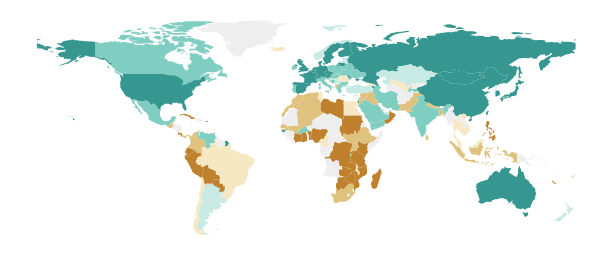

In [24]:
bins, worldMap = plotMap(toPlot, col='Percentage', minTotal=100)
plt.savefig('../figures/upon_request_map.pdf', bbox_inches = 'tight', pad_inches = 0)

In [25]:
bins

,Percentage_Q,Percentage_max,Color
0,1,0.207317,#bf812d
1,2,0.234082,#dfc27d
2,3,0.251716,#f6e8c3
3,4,0.260000,#c7eae5
4,5,0.294678,#80cdc1
5,6,0.534884,#35978f


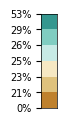

In [26]:
plotPallete(bins.Color, list(bins.Percentage_max), vertical=True, scale=0.4, rounding=2, minVal=worldMap.Percentage.min())

plt.savefig('../figures/upon_request_map_legend_small.pdf', bbox_inches = 'tight', pad_inches = 0)

## Plot distribution

In [27]:
import seaborn as sns
from scipy.stats import ttest_ind

def plotPvalue(ax, x, height, pVal, gap, vlength, lw=0.2, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap, yPos, color=c, lw=lw)
    
    stars = '$p$ < 0.001' if pVal < 0.001 else f'$p$ = {round(pVal, 3)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos , stars, ha='center', va='bottom', color=c)
    
    return yPos

In [28]:
toPlot.query('GlobalSouth==False').Percentage.mean(), toPlot.query('GlobalSouth==True').Percentage.mean()

(0.25874373612888524, 0.20920846495427164)

In [29]:
from numpy import std, mean, sqrt

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

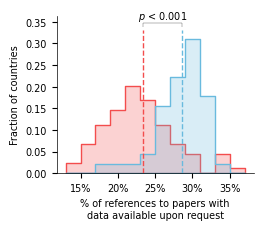

In [30]:
import seaborn as sns
from scipy.stats import ttest_ind

ax = plt.gca()

toPlot = toPlot.query('Total >= 100')

bins = [x/100 for x in range(13, 38, 2)]

sns.histplot(
    toPlot, x="Percentage", hue="GlobalSouth", element="step", bins=bins,
    stat="probability", common_norm=False, palette={True: '#f34d4d', False: '#69bade'}
)

whiteMean = toPlot.query('GlobalSouth==False').Percentage.mean()
nonWhiteMean = toPlot.query('GlobalSouth==True').Percentage.mean()

plt.plot([whiteMean, whiteMean], [0, 0.33], color='#69bade', lw=1, ls='--')
plt.plot([nonWhiteMean, nonWhiteMean], [0, 0.33], color='#f34d4d', lw=1, ls='--')

tstat, p = ttest_ind(
    toPlot.query('GlobalSouth==False').Percentage,
    toPlot.query('GlobalSouth==True').Percentage
)

plotPvalue(ax, [whiteMean, nonWhiteMean], 0.33, pVal=p, gap=0.007, vlength=0.01)


set_size(5*cm, 4*cm, ax)

ax.set_xlabel('% of references to papers with\ndata available upon request')
ax.set_ylabel('Fraction of countries')

ax.set_xticks([0.15, 0.2, 0.25, 0.3, 0.35])
ax.set_xticklabels(['15%', '20%', '25%', '30%', '35%'])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend([],[], frameon=False)

plt.savefig('../figures/uponrequest_distribution.pdf',bbox_inches = 'tight', pad_inches = 0)

In [31]:
tstat, p, cohen_d(toPlot.query('GlobalSouth==False').Percentage, toPlot.query('GlobalSouth==True').Percentage)

(5.633547755626285, 9.863137654278392e-08, 1.0191606609038382)

In [32]:
toPlot.query('GlobalSouth==False').shape, toPlot.query('GlobalSouth==True').shape

((46, 8), (91, 8))

# Randomized netowrk

In [33]:
%%time
sameCountryRandomized = (
    pd.read_csv(f'{LARGEFILE}/SameCountryRandomized.csv', usecols=['CitingPaperID','CitedPaperID'])
    .pipe(printShape)
    .drop_duplicates()
    .pipe(printShape)
    .rename(columns={'CitedPaperID':'PaperID'})
)
# (131383667, 2)  
# (124530548, 2)  

(131383667, 2)  
(124530548, 2)  
CPU times: user 59.5 s, sys: 7.49 s, total: 1min 6s
Wall time: 2min 19s


In [34]:
%%time
selfCiteRandomized = (
    pd.read_csv(f'{DIR}/SelfCitationsRandomized.csv', usecols=['CitingPaperID','CitedPaperID'])
    .pipe(printShape)
    .drop_duplicates()
    .pipe(printShape)
    .rename(columns={'CitedPaperID':'PaperID'})
)
# (4176, 2)  
# (4176, 2)  

(4176, 2)  
(4176, 2)  
CPU times: user 2.83 ms, sys: 1.53 ms, total: 4.36 ms
Wall time: 10.3 ms


In [35]:
originalRemoveSameCountry = countryCitationsUponRequest(citations, byYear=False)

(5040838, 6)  PaperID 78008  CitingPaperID 2630587  
(2959546, 7)  PaperID 77136  CitingPaperID 1820497  


In [ ]:
%%time
randomizedDfsRemoveSameCountry = []

for epoch in tqdm(range(10)):

    randomizedNetwork = pd.read_csv(f'{DIR}/randomized_network_data/{epoch}.csv')

    randomizedToPlot = countryCitationsUponRequest(randomizedNetwork, sameCountryRandomized, selfCiteRandomized, byYear=True)
    randomizedDfsRemoveSameCountry.append(randomizedToPlot.assign(Epoch=epoch))
    
randomizedDfRemoveSameCountry = pd.concat(randomizedDfsRemoveSameCountry, ignore_index=True, sort=False)

randomizedDfRemoveSameCountry.to_csv(
    f'{DIR}/RandomizedDataAvailabilityCitationNetwork_withoutSameCountryCitation.csv', index=False
)

In [38]:
randomizedDfRemoveSameCountry = pd.read_csv(
    f'{DIR}/RandomizedDataAvailabilityCitationNetwork_withoutSameCountryCitation.csv'
)

In [39]:
%%time
import numpy as np
import scipy

def CI(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h


orig = (
    originalRemoveSameCountry
    .assign(Percentage=lambda df: df.UnavailableCount/df.Total)
)

origMean = originalRemoveSameCountry.groupby(['GlobalSouth']).Percentage.mean().reset_index()
origCI = originalRemoveSameCountry.groupby(['GlobalSouth']).Percentage.apply(CI).reset_index()

randToPlot = (
    randomizedDfRemoveSameCountry
    .groupby(['country_code','GlobalSouth']).agg({'Total': 'sum', 'UnavailableCount': 'sum'}).reset_index()
    .assign(Percentage=lambda df: df.UnavailableCount/df.Total)
)

randToPlot = randToPlot[randToPlot.country_code.isin(orig.country_code)]

randMean = randToPlot.groupby(['GlobalSouth']).Percentage.mean().reset_index()
randCI = randToPlot.groupby(['GlobalSouth']).Percentage.apply(CI).reset_index()

CPU times: user 12.4 ms, sys: 2 ms, total: 14.4 ms
Wall time: 23 ms


In [40]:
randMean # 0.320851, 0.316361

,GlobalSouth,Percentage
0,False,0.320851
1,True,0.316361


In [41]:
from numpy import std, mean, sqrt

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

In [42]:
def plotPvalue(ax, x, height, pVal, gap, vlength, lw=0.2, c='black', tstat=''):
    # x: [x0, x1]
    # y: [y0, y1]
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap, yPos, color=c, lw=lw)
    
    stars = 'p < 0.001' if pVal < 0.001 else f'p = {round(pVal, 3)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos , f'{tstat}\n{stars}', ha='center', va='bottom', color=c)
    
    return yPos

Original $t_216$ 3.45 0.0007
Randomized  $t_216$ 0.71 0.4798


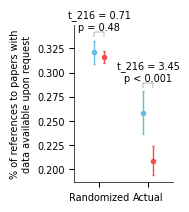

In [43]:
ax = plt.gca()

ax.errorbar(
    x=0-0.1, y=randMean.query('GlobalSouth==False').Percentage.values[0], color='#69bade', lw=1, markersize=3, fmt='o', capsize=1, 
    yerr=randCI.query('GlobalSouth==False').Percentage.values[0]
)

ax.errorbar(
    x=0+0.1, y=randMean.query('GlobalSouth==True').Percentage.values[0], color='#f34d4d', lw=1, markersize=3, fmt='o', capsize=1, 
    yerr=randCI.query('GlobalSouth==True').Percentage.values[0]
)

ax.errorbar(
    x=1-0.1, y=origMean.query('GlobalSouth==False').Percentage.values[0], color='#69bade', lw=1, markersize=3, fmt='o', capsize=1, 
    yerr=origCI.query('GlobalSouth==False').Percentage.values[0]
)

ax.errorbar(
    x=1+0.1, y=origMean.query('GlobalSouth==True').Percentage.values[0], color='#f34d4d', lw=1, markersize=3, fmt='o',  capsize=1, 
    yerr=origCI.query('GlobalSouth==True').Percentage.values[0]
)

tstat, p = ttest_ind(
    orig.query('GlobalSouth==False').Percentage,
    orig.query('GlobalSouth==True').Percentage
)

dof = orig.query('GlobalSouth==False').shape[0] + orig.query('GlobalSouth==True').shape[0] - 2
print(f'Original $t_{dof}$ {tstat:.2f} {p:.4f}')

plotPvalue(ax, [1-0.1, 1.1], 0.272, pVal=p, gap=0.012, vlength=0.005, tstat=f't_{dof} = {tstat:.2f}')


tstat, p = ttest_ind(
    randToPlot.query('GlobalSouth==False').Percentage,
    randToPlot.query('GlobalSouth==True').Percentage
)

dof = randToPlot.query('GlobalSouth==False').shape[0] + randToPlot.query('GlobalSouth==True').shape[0] - 2
print(f'Randomized  $t_{dof}$ {tstat:.2f} {p:.4f}')

plotPvalue(ax, [-0.1, 0.1], 0.325, pVal=p, gap=0.012, vlength=0.005, tstat=f't_{dof} = {tstat:.2f}')


ax.set_xlim(-0.5, 1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Randomized', 'Actual'])

ax.set_ylabel('% of references to papers with\ndata available upon request')

set_size(2.5*cm, 4*cm, ax)

plt.savefig('../figures/uponrequest_randomized_remove_same_country.pdf',bbox_inches = 'tight', pad_inches = 0)

In [44]:
cohen_d(randToPlot.query('GlobalSouth==False').Percentage,
    randToPlot.query('GlobalSouth==True').Percentage)

0.10910954809741671

In [534]:
GDP = pd.read_csv('/scratch/fl1092/data_common/world_data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_76261.csv')

In [535]:
continents.head()

,name,country_code,iso3,region,sub-region,nonWhite
0,Afghanistan,AF,AFG,Asia,Southern Asia,True
1,Åland Islands,AX,ALA,Europe,Northern Europe,False
2,Albania,AL,ALB,Europe,Southern Europe,False
3,Algeria,DZ,DZA,Africa,Northern Africa,True
4,American Samoa,AS,ASM,Oceania,Polynesia,True


In [47]:
import numpy as np

expenditure = (
    RD[['Country Code', '2019']].rename(columns={'2019': 'PercentRD'})
    .merge(
        GDP[['Country Name', 'Country Code', '2019']].rename(columns={'2019': 'GDP'}), on='Country Code'
    )
    .pipe(printShape)
    .dropna(subset=['GDP'])
    .pipe(printShape, msg='remove NA values GDP')

    .rename(columns={'Country Code': 'iso3'})
    .merge(continents, on='iso3')
    .pipe(printShape)

    .assign(RD=lambda df: df.GDP * df.PercentRD * 0.01)
    .assign(LogGDP=lambda df: df.GDP.apply(lambda x: np.log10(x)))
    .assign(LogRD=lambda df: df.RD.apply(lambda x: np.log10(x)))

    .merge(toPlot, on='country_code')
    .pipe(printShape)
)

(266, 4)  
(258, 4)  remove NA values GDP
(207, 9)  
(201, 21)  


In [141]:
import seaborn as sns
from scipy.stats import pearsonr

def plotReg(df, ax, x, y):

    df = df.dropna(subset=[x, y]).pipe(printShape)

    sns.regplot(data=df, x=x, y=y, scatter_kws={'s': 4, 'linewidths': 0}, line_kws={'lw': 1})

    # print(pearsonr(df[x], df[y]))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #ax.set_ylabel('% of references that are Open Access')

    return pearsonr(df[x], df[y])

(201, 21)  


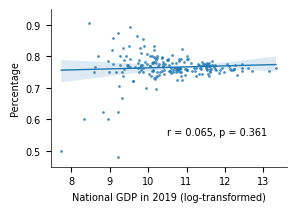

In [142]:
ax = plt.gca()
res = plotReg(expenditure, ax, 'LogGDP', 'Percentage')
ax.set_ylim(0.45, 0.95)
ax.text(10.5, 0.55, f'r = {res.statistic:.3f}, p = {res.pvalue:.3f}')
ax.set_xlabel('National GDP in 2019 (log-transformed)')

set_size(6*cm, 4*cm, ax)

plt.savefig('../figures/upon_request_GDP.pdf', bbox_inches='tight', pad_inches=0)

# Regressions

In [82]:
from statsmodels.formula.api import ols, logit
from scipy.stats import ttest_ind
from statsmodels.iolib.summary2 import summary_col

In [83]:
import numpy as np

def cleanContentType(x):
    
    if pd.isna(x):
        return 'unknown'
    
    x = x.lower()
    return x

def getDataFrame(nonWhiteCount, countryWhiteness):

    with pd.option_context('future.no_silent_downcasting', True):
        
        toRegress = (
            df
            .pipe(printShape, cols=['PaperID'])
            
            .merge(citationCount, on='PaperID')
            .pipe(printShape, cols=['PaperID'], msg='papers cited at least once')
        
            .merge(
                nonWhiteCount.query('NonWhite==True').assign(CitedByNonWhite=1).drop('NonWhite', axis=1),
                on='PaperID', how='left'
            )
            
            .assign(content_type=lambda df: df.content_type.apply(cleanContentType))
            
            .fillna({'CitedByNonWhite': 0, 'Count': 0})
            .pipe(printShape, cols=['PaperID'])
        
            .assign(Percentage=lambda df: df.Count/df.TotalCitations)
            #.assign(Count=lambda df: df.Count.apply(lambda x: np.log(x+0.1)))
        
            .dropna(subset=['data_availability'])
            .pipe(printShape, cols=['PaperID'], msg='remove NA values')
        
            .merge(paperField, on='PaperID')
            .pipe(printShape, cols=['PaperID'], msg='get paper field')
            
            .merge(paperCountry, on='PaperID')
            .pipe(printShape, cols=['PaperID'], msg='get paper country')
        )
    return toRegress


In [84]:
countryWhiteToRegress = getDataFrame(countryAllNSCitation, allNorthSouth).pipe(printShape)
# (91386, 9)  PaperID 91386  
# (91386, 10)  PaperID 91386  
# (78008, 11)  PaperID 78008  papers cited at least once
# (78008, 14)  PaperID 78008  
# (44182, 15)  PaperID 44182  remove NA values
# (44181, 17)  PaperID 44181  get paper field
# (44181, 17)  

(91386, 9)  PaperID 91386  
(78008, 10)  PaperID 78008  papers cited at least once
(78008, 12)  PaperID 78008  
(44182, 13)  PaperID 44182  remove NA values
(44181, 15)  PaperID 44181  get paper field
(44181, 16)  PaperID 44181  get paper country
(44181, 16)  


### VIF

In [85]:
import numpy as np
import pandas as pd

def generalized_VIF(df):
    '''
    Calculates the Generalized VIF (GVIF, Fox and Monette 1992) for a data set. GVIF ** (1 / (2 * Df)) ** 2 < 5 is equivalent to VIF.
    The function assumes that categorical data are typed as 'category' or 'object' and automatically performs one-hot encoding. The function
    will work properly if the data frame has columns previously one-hot encoded from binary data, but it will not work properly if the data 
    frame has multi-nomial columns that have been previously one-hot encoded.

    Args:
        df (pandas data frame): Data frame with the response column(s) removed

    Returns:
        pandas data frame: a data frame, indexed by factor of the GVIF, GVIF^(1/2Df), VIF^(1/2Df)^2 
        dictionary: Dictionary of column names (keys) and GVIF ** (1 / (2 * Df)) ** 2 (values)
    '''

    # Save categorical column names, append with prefix
    onehot_list = list(df.select_dtypes(include=['category', 'object', 'string']).columns)

    # Since we do not include all of the indicator variables in the model so as to avoid the dummy variable trap,
    # one of the indicator variables is dropped
    df_1hot = pd.get_dummies(df, drop_first=True, dummy_na=False, prefix_sep='_', dtype=int)
    
    # print(df_1hot)

    # Create empty df to store GVIF results
    gvif_df = pd.DataFrame(columns = ['factor', 'GVIF', 'GVIF^(1/2Df)', 'GVIF^(1/2Df)^2'])

    # Iterate over columns
    for (columnName, columnData) in df.items():
        
        # print(columnName)

        # Select predictor as response: if dummy encoded, select all columns for variable
        # Could all be done in the first condition, but that could result in incorrect column selection 
        # with similar column names
        if columnName in onehot_list:
            X1 = df_1hot.loc[:, df_1hot.columns.str.startswith(columnName)]
            X2 = df_1hot.loc[:, ~df_1hot.columns.str.startswith(columnName)]
        else:
            X1 = df_1hot[[columnName]].values
            X2 = df_1hot.loc[:, df_1hot.columns != columnName].values
            
        # print(X2)

        # Calculate gvif
        gvif = np.linalg.det(np.array(np.corrcoef(X1, rowvar=False), ndmin=2)) * np.linalg.det(np.corrcoef(X2, rowvar=False)) / np.linalg.det(np.corrcoef(np.append(X1, X2, axis=1), rowvar=False))

        gvif_12df = np.power(gvif, 1 / (2 * X1.shape[1]))
        gvif_12df_sq = gvif_12df ** 2

        # Update results df
        new_row = {
            'factor': columnName, 'GVIF': f'{gvif:.3e}' if gvif > 100 else f'{gvif:.3f}',
            'GVIF^(1/2Df)': f'{gvif_12df:.3e}' if gvif_12df > 100 else f'{gvif_12df:.3f}',
            'GVIF^(1/2Df)^2': f'{gvif_12df_sq:.3e}' if gvif_12df_sq > 100 else f'{gvif_12df_sq:.3f}',
        }

        gvif_df = pd.concat([gvif_df, pd.DataFrame([new_row])], ignore_index=True, sort=False)

    gvif_df = gvif_df.set_index('factor')
    # gvif_filter = gvif_df.loc[gvif_df['GVIF^(1/2Df)^2'] >= 5]['GVIF^(1/2Df)^2'].to_dict()

    return gvif_df#, gvif_filter

In [86]:
gvif_df = generalized_VIF(
    (
        countryWhiteToRegress
        .assign(is_open_access=lambda df: df.is_open_access.apply(int))
        .assign(UponRequest=lambda df: df.UponRequest.apply(int))
        .assign(NewData=lambda df: df.NewData.apply(int))
        [['Year','is_open_access','UponRequest','NewData','Journal']]
    )
)

gvif_df

,GVIF,GVIF^(1/2Df),GVIF^(1/2Df)^2
factor,,,
Year,1.030,1.015,1.030
is_open_access,4.097,2.024,4.097
UponRequest,6.504,2.550,6.504
NewData,6.722,2.593,6.722
Journal,5.972,1.161,1.347


In [87]:
gvif_df = generalized_VIF(
    (
        countryWhiteToRegress
        .assign(is_open_access=lambda df: df.is_open_access.apply(int))
        .assign(UponRequest=lambda df: df.UponRequest.apply(int))
        .assign(NewData=lambda df: df.NewData.apply(int))
        [['Year','is_open_access','UponRequest','NewData','Journal','domain_display_name']]
    )
)

gvif_df

,GVIF,GVIF^(1/2Df),GVIF^(1/2Df)^2
factor,,,
Year,1.032,1.016,1.032
is_open_access,4.101,2.025,4.101
UponRequest,6.516,2.553,6.516
NewData,6.737,2.596,6.737
Journal,6.703,1.172,1.373
domain_display_name,1.145,1.023,1.046


In [88]:
gvif_df = generalized_VIF(
    (
        countryWhiteToRegress
        .assign(is_open_access=lambda df: df.is_open_access.apply(int))
        .assign(UponRequest=lambda df: df.UponRequest.apply(int))
        .assign(NewData=lambda df: df.NewData.apply(int))
        [['Year','is_open_access','UponRequest','NewData','Journal','domain_display_name', 'content_type']]
    )
)

gvif_df

,GVIF,GVIF^(1/2Df),GVIF^(1/2Df)^2
factor,,,
Year,1.072,1.035,1.072
is_open_access,4.218,2.054,4.218
UponRequest,6.521,2.554,6.521
NewData,6.739,2.596,6.739
Journal,3.739e+03,1.985,3.940
domain_display_name,1.163,1.025,1.051
content_type,1.236e+03,1.160,1.345


In [89]:
gvif_df = generalized_VIF(
    (
        countryWhiteToRegress
        .assign(is_open_access=lambda df: df.is_open_access.apply(int))
        .assign(UponRequest=lambda df: df.UponRequest.apply(int))
        .assign(NewData=lambda df: df.NewData.apply(int))
        [['Year','is_open_access','UponRequest','NewData','Journal','domain_display_name',
          'field_display_name', 'content_type'
         ]]
    )
)

gvif_df

/tmpdata/ipykernel_4048928/929113494.py:51: RuntimeWarning: invalid value encountered in power
  gvif_12df = np.power(gvif, 1 / (2 * X1.shape[1]))


,GVIF,GVIF^(1/2Df),GVIF^(1/2Df)^2
factor,,,
Year,0.918,0.958,0.918
is_open_access,4.554,2.134,4.554
UponRequest,7.694,2.774,7.694
NewData,7.116,2.668,7.116
Journal,3.879e+03,1.991,3.964
domain_display_name,-86917751091543363128041894945692027954659328.000,nan,nan
field_display_name,-154490215447732902057618932708845319016677376...,nan,nan
content_type,1.345e+03,1.162,1.350


In [90]:
gvif_df = generalized_VIF(
    (
        countryWhiteToRegress
        .assign(is_open_access=lambda df: df.is_open_access.apply(int))
        .assign(UponRequest=lambda df: df.UponRequest.apply(int))
        .assign(NewData=lambda df: df.NewData.apply(int))
        [['Year','is_open_access','UponRequest','NewData','Journal', 'field_display_name','content_type']]
    )
)

gvif_df

,GVIF,GVIF^(1/2Df),GVIF^(1/2Df)^2
factor,,,
Year,1.075,1.037,1.075
is_open_access,4.241,2.059,4.241
UponRequest,6.550,2.559,6.550
NewData,6.767,2.601,6.767
Journal,4.031e+03,1.997,3.989
field_display_name,1.379,1.006,1.013
content_type,1.283e+03,1.161,1.347


In [91]:
gvif_df = generalized_VIF(
    (
        countryWhiteToRegress
        .assign(is_open_access=lambda df: df.is_open_access.apply(int))
        .assign(UponRequest=lambda df: df.UponRequest.apply(int))
        .assign(NewData=lambda df: df.NewData.apply(int))
        [['Year','is_open_access','UponRequest','NewData','Journal', 'field_display_name', 'country_code','content_type']]
    )
)

gvif_df

,GVIF,GVIF^(1/2Df),GVIF^(1/2Df)^2
factor,,,
Year,1.082,1.040,1.082
is_open_access,4.250,2.062,4.250
UponRequest,6.602,2.569,6.602
NewData,6.820,2.612,6.820
Journal,4.440e+03,2.013,4.054
field_display_name,1.665,1.010,1.021
country_code,1.674,1.002,1.004
content_type,1.445e+03,1.164,1.354


### OLS regression

In [92]:
m1 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS'))"

m2 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS')) + \
C(domain_display_name, Treatment(reference='Health Sciences'))"

m3 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS')) + \
C(domain_display_name, Treatment(reference='Health Sciences')) + C(content_type)"

m4 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS')) + \
C(field_display_name) + C(content_type)"

m5 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS')) + \
C(field_display_name) + C(country_code) + C(content_type)"

In [93]:
%%time
m1 = ols(m1, data=countryWhiteToRegress).fit()
m2 = ols(m2, data=countryWhiteToRegress).fit()
m3 = ols(m3, data=countryWhiteToRegress).fit()
m4 = ols(m4, data=countryWhiteToRegress).fit()
m5 = ols(m5, data=countryWhiteToRegress).fit()

CPU times: user 3.54 s, sys: 65.7 ms, total: 3.61 s
Wall time: 7.25 s


In [94]:
summary_col(
    [m1, m2, m3, m4, m5], stars=True, drop_omitted=True, #float_format='.3f',
    model_names=['Model I', 'Model II', 'Model III', 'Model IV', 'Model V'],
    regressor_order=['NewData[T.True]','UponRequest[T.True]','is_open_access[T.True]','Year']
)

,Model I,Model II,Model III,Model IV,Model V
NewData[T.True],0.0466***,0.0490***,0.0490***,0.0354***,0.0212***
,(0.0043),(0.0042),(0.0042),(0.0040),(0.0033)
UponRequest[T.True],-0.0207***,-0.0247***,-0.0249***,-0.0218***,-0.0126***
,(0.0042),(0.0042),(0.0042),(0.0039),(0.0032)
is_open_access[T.True],-0.0052,-0.0031,-0.0014,-0.0012,-0.0121***
,(0.0061),(0.0060),(0.0061),(0.0057),(0.0047)
Year,0.0129***,0.0130***,0.0132***,0.0129***,0.0082***
,(0.0010),(0.0010),(0.0010),(0.0010),(0.0008)
R-squared,0.0386,0.0672,0.0693,0.1784,0.4499
R-squared Adj.,0.0384,0.0669,0.0685,0.1773,0.4476


### Beta regression

In [95]:
from statsmodels.othermod.betareg import BetaModel

In [98]:
m1 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS'))"

m2 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS')) + \
C(domain_display_name, Treatment(reference='Health Sciences'))"

m3 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS')) + \
C(domain_display_name, Treatment(reference='Health Sciences')) + C(content_type)"

m4 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS')) + \
C(field_display_name) + C(content_type)"

m5 = f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(Journal, Treatment(reference='PNAS')) + \
C(field_display_name) + C(country_code) + C(content_type)"


m1Beta = BetaModel.from_formula(m1, data=countryWhiteToRegress.query('Percentage > 0 & Percentage < 1')).fit()
m2Beta = BetaModel.from_formula(m2, data=countryWhiteToRegress.query('Percentage > 0 & Percentage < 1')).fit()
m3Beta = BetaModel.from_formula(m3, data=countryWhiteToRegress.query('Percentage > 0 & Percentage < 1')).fit()
m4Beta = BetaModel.from_formula(m4, data=countryWhiteToRegress.query('Percentage > 0 & Percentage < 1')).fit()
m5Beta = BetaModel.from_formula(m5, data=countryWhiteToRegress.query('Percentage > 0 & Percentage < 1')).fit()

In [99]:
summary_col(
    [m1Beta, m2Beta, m3Beta, m4Beta, m5Beta], stars=True, drop_omitted=True,
    model_names=['Beta Regression I', 'Beta Regression II', 'Beta Regression III', 'Beta Regression IV', 'Beta Regression V'],
    regressor_order=['NewData[T.True]','UponRequest[T.True]','is_open_access[T.True]','Year']
)

,Beta Regression I,Beta Regression II,Beta Regression III,Beta Regression IV,Beta Regression V
NewData[T.True],0.2129***,0.2295***,0.2296***,0.1649***,0.1039***
,(0.0206),(0.0204),(0.0204),(0.0197),(0.0174)
UponRequest[T.True],-0.0964***,-0.1126***,-0.1133***,-0.1004***,-0.0625***
,(0.0202),(0.0200),(0.0200),(0.0194),(0.0171)
is_open_access[T.True],-0.0304,-0.0171,-0.0107,-0.0232,-0.0818***
,(0.0306),(0.0304),(0.0307),(0.0295),(0.0262)
Year,0.0786***,0.0793***,0.0805***,0.0792***,0.0595***
,(0.0051),(0.0050),(0.0051),(0.0049),(0.0044)


### Main figure analysis

In [48]:
def regress(toRegress, col=None, value=None, outcome=None):

    if value is not None:
        subset = toRegress.query(f'{col} == "{value}"')
    else:
        subset = toRegress.copy()

    if outcome == "Percentage":
        m = ols(f"Percentage ~ NewData + UponRequest + is_open_access + Year + C(content_type) + C(Journal, Treatment(reference='PNAS')) + C(domain_display_name, Treatment(reference='Health Sciences'))", data=subset).fit()
    elif outcome == "Count":
        m = ols(f"Count ~ NewData + UponRequest + is_open_access + TotalCitations + Year + C(content_type) + C(Journal, Treatment(reference='PNAS')) + C(domain_display_name, Treatment(reference='Health Sciences'))", data=subset).fit()
    
    meanConfInt = (
        m.conf_int().assign(Mean = lambda df: (df[0] + df[1])/2)
        .rename(columns={0:'lo', 1:'hi'})
        .assign(err = lambda df: (df.hi-df.lo)/2)
        .reset_index()
        .rename(columns={'index':'Control'})
        .merge(m.pvalues.reset_index(name='pvalue').rename(columns={'index':'Control'}), on='Control')
        .assign(Keep=lambda df: df.Control.apply(lambda x: 'C(Journal' in x or 'C(domain_display_name' in x or ('C(' not in x and x != 'Intercept')))
        .query('Keep==True')
    )
    meanConfInt[col] = value if value is not None else 'All domains'

    return meanConfInt

In [49]:
def regressBoth(whiteness, outcome, field=True):

    res = []
    res.append(regress(whiteness, col='domain_display_name', value=None, outcome=outcome))
    

    for domain in fieldDomain.domain_display_name.unique():
        res.append(regress(whiteness, col='domain_display_name', value=domain, outcome=outcome))
    
    domainToPlot = pd.concat(res, ignore_index=True, sort=False).pipe(printShape).merge(sequence, on='domain_display_name').pipe(printShape)

    if field:
        res = []
        for field in fieldDomain.field_display_name.unique():
            res.append(regress(whiteness, col='field_display_name', value=field, outcome=outcome))
        
        fieldToPlot = (
            pd.concat(res, ignore_index=True, sort=False)
            .pipe(printShape)
            .merge(fieldDomain, on='field_display_name')
            .merge(sequence, on='domain_display_name')
            .pipe(printShape)
        )
    else:
        fieldToPlot = None

    return domainToPlot, fieldToPlot

In [50]:
def plotReg(toPlot, ax, col):

    ind = 0
    ticks = []
    for _, row in toPlot.iterrows():

        ticks.append(ind)

        if pd.isna(row['pvalue']):
            ind += 1
            continue
    
        if row['pvalue'] < 0.05:
            color = 'tab:orange'
        else:
            color = 'black'
    
        ax.errorbar(
            y = ind, x = row['Mean'], xerr = [[row['Mean'] - row['lo']], [row['hi'] - row['Mean']]],
            fmt = 'o', color = color, markersize=1.5, capsize=1, lw=0.5
        )

        ind += 1
        

    ax.set_yticks(ticks)
    # ax.set_yticklabels(toPlot[col])

    # ax.tick_params(rotation=90, axis='x')

    ax.plot([0, 0], [0-0.5, toPlot.shape[0] - 0.5], lw=0.5, ls='--', color='black')
    ax.set_ylim([0-0.5, toPlot.shape[0] - 0.5])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [51]:
sequence = pd.DataFrame(
    {
        'domain_display_name': ['All domains', 'Physical Sciences', 'Social Sciences', 'Health Sciences', 'Life Sciences'],
        'seq': [4, 3, 2, 1, 0]
    }
)

In [52]:
results = regress(countryWhiteToRegress, outcome='Percentage')

results = pd.concat([
    results[results.Control.apply(lambda x: 'Journal' in x)].sort_values(by='Mean'),
    pd.DataFrame({'Control':['']}),
    pd.DataFrame({'Control':['']}),
    
    results[results.Control.apply(lambda x: 'domain_display_name' in x)].sort_values(by='Mean'),
    pd.DataFrame({'Control':['']}),
    pd.DataFrame({'Control':['']}),
    
    results[results.Control.apply(lambda x: 'domain_display_name' not in x and 'Journal' not in x)].sort_values(by='Mean'),
], ignore_index=True, sort=False)

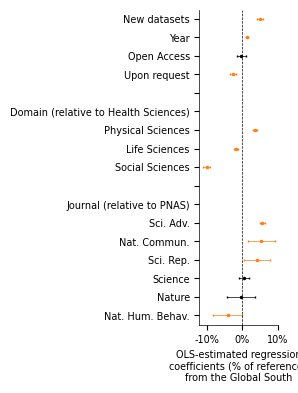

In [53]:
ax = plt.gca()

plotReg(results, ax, 'Control')
ax.set_yticklabels([
    'Nat. Hum. Behav.','Nature','Science','Sci. Rep.','Nat. Commun.', 'Sci. Adv.', 'Journal (relative to PNAS)', '',
    'Social Sciences', 'Life Sciences', 'Physical Sciences', 'Domain (relative to Health Sciences)', '',
    'Upon request', 'Open Access', 'Year', 'New datasets'
])
ax.set_xlabel('OLS-estimated regression\ncoefficients (% of references\nfrom the Global South')

ax.set_xticks([-0.1, 0, 0.1])
ax.set_xticklabels(['-10%', '0%', '10%'])

set_size(2*cm, 8*cm, ax)
plt.savefig('../figures/uponrequest_regression.pdf',bbox_inches = 'tight', pad_inches = 0)